In [1]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

sns.set()

## Import preprocessed data

In [2]:
df = pd.read_csv(join('..', 'data', 'tugas_preprocessed.csv'))

In [3]:
df.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x_status_Widow,x_gender_M,x_dependents_1.0,x_description_Kind of OK,x_description_Meh...,x_description_OK nice!,x_description_Take my money!!,PC0,PC1,PC2
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376


In [4]:
df.columns

Index(['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances',
       'toys', 'house_keeping', 'per_net_purchase', 'spent_online',
       'x_education_2nd Cycle', 'x_education_Graduation', 'x_education_Master',
       'x_education_PhD', 'x_status_Married', 'x_status_Single',
       'x_status_Together', 'x_status_Widow', 'x_gender_M', 'x_dependents_1.0',
       'x_description_Kind of OK', 'x_description_Meh...',
       'x_description_OK nice!', 'x_description_Take my money!!', 'PC0', 'PC1',
       'PC2'],
      dtype='object')

In [5]:
# Splitting feature names into groups
non_metric_features = df.columns[df.columns.str.startswith('x')]
pc_features = df.columns[df.columns.str.startswith('PC')]
metric_features = df.columns[~df.columns.str.startswith('x') & ~df.columns.str.startswith('PC')]

## K-Means Clustering
What is K-Means clustering? How does it work?

### How is it computed?
![](../data/kmeans.png)

### Characteristics:
- *Number of clusters* need to be set apriori
- One of the *fastest* clustering algorithms
- The results *depend on the initialization* (stochastic)
- Prone to *local optima*
- Favors *convex* (round shape) and *isotropic* (same shape) clusters

**Some videos showing how K-Means works:**

(You might want to mute the videos before playing)

How K-Means works: https://www.youtube.com/watch?v=5I3Ei69I40s

Effects of different initializations: https://www.youtube.com/watch?v=9nKfViAfajY



### How to apply K-Means clustering?

In [6]:
kmclust = KMeans(n_clusters=2, init="random", n_init=1, random_state=None)
kmclust.fit(df[metric_features])

KMeans(init='random', n_clusters=2, n_init=1)

In [7]:
kmclust.predict(df[metric_features])

array([0, 0, 1, ..., 1, 0, 0], dtype=int32)

In [8]:
distances = kmclust.transform(df[metric_features])
distances

array([[2.26026263, 3.76833487],
       [2.654817  , 4.75349249],
       [4.82021785, 2.79024935],
       ...,
       [3.32316552, 2.23886356],
       [2.30155399, 2.95227052],
       [3.55952131, 5.97919855]])

### How can we improve the initialization step?

In [9]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=8, init='k-means++', n_init=15, random_state=1)
kmclust.fit(df[metric_features])

KMeans(n_init=15, random_state=1)

In [10]:
kmclust.predict(df[metric_features])

array([3, 3, 6, ..., 5, 7, 0], dtype=int32)

*init='k-means++'* initializes the centroids to be (generally) distant from each other, leading to probably better results than random initialization. *n_init=K* allows to initialize KMeans K times and pick the best clustering in terms of Inertia. This can been shown in the link below.

**Empirical evaluation of the impact of k-means initialization:**

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_stability_low_dim_dense.html#sphx-glr-auto-examples-cluster-plot-kmeans-stability-low-dim-dense-py

### Defining the number of clusters:

In [11]:
range_clusters = range(2, 11)

In [12]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust =  KMeans(n_clusters=n_clus, init="k-means++", n_init=15, random_state=42)
    kmclust.fit(df[metric_features])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

**Inertia (within-cluster sum-of-squares distance) Formula:**
$$\sum_{j=0}^{C}\sum_{i=0}^{n_j}(||x_i - \mu_j||^2)$$
, where:

$C$: Set of identified clusters.

$n_j$: Set of observations belonging to cluster $j$.

$x_i$: Observation $i$.

$\mu_j$: Centroid of cluster $j$.

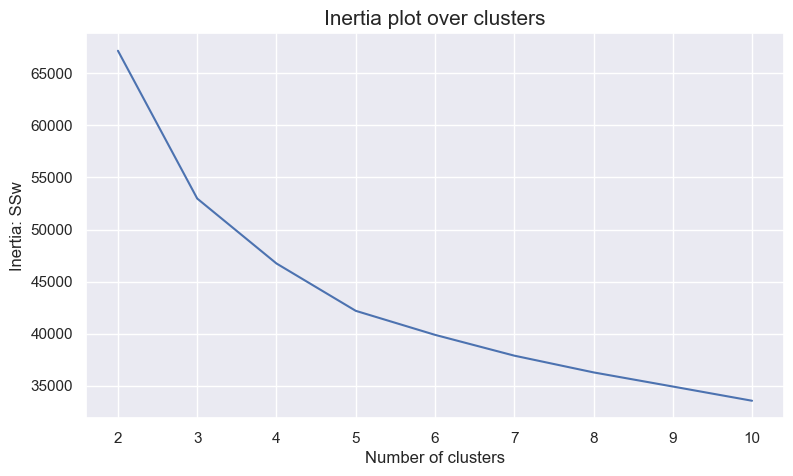

In [13]:
# The inertia plot
plt.figure(figsize=(9,5))

plt.plot(range_clusters,   ## Plot X-axis: What should be in the X-axis?
         inertia)        ## Plot Y-axis

plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

---

**Silhouette Coefficient formula for a single sample:**
$$s = \frac{b - a}{max(a, b)}$$
, where:
- $a$: The mean distance between a sample and all other points in the same cluster.
- $b$: The mean distance between a sample and all other points in the next nearest cluster

---


If $b > a$, then what?

Then the sample is closer to the points in the cluster it is assigned to (compared to the points in the next nearest cluster)

$s$ is positive

---


If $b = a$, then what?

*Then the sample is equally distant to the points in the cluster it is assigned to as well as the points in the next closest cluster*

$s$ is 0

---

If $b < a$, then what?

*Then the sample is closer to the points in the next closest cluster (compared to the points in the same cluster).*

$s$ is negative

---

**If the average value of $s$ is high, then what?**


"Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster."

- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html





For n_clusters = 2, the average silhouette_score is : 0.22169256242414487
For n_clusters = 3, the average silhouette_score is : 0.23695132157473936
For n_clusters = 4, the average silhouette_score is : 0.2104913373443331
For n_clusters = 5, the average silhouette_score is : 0.1948602842135274
For n_clusters = 6, the average silhouette_score is : 0.18736793579734382
For n_clusters = 7, the average silhouette_score is : 0.1698859786145844
For n_clusters = 8, the average silhouette_score is : 0.1668813803550606
For n_clusters = 9, the average silhouette_score is : 0.1574004473618112
For n_clusters = 10, the average silhouette_score is : 0.1510092734412441


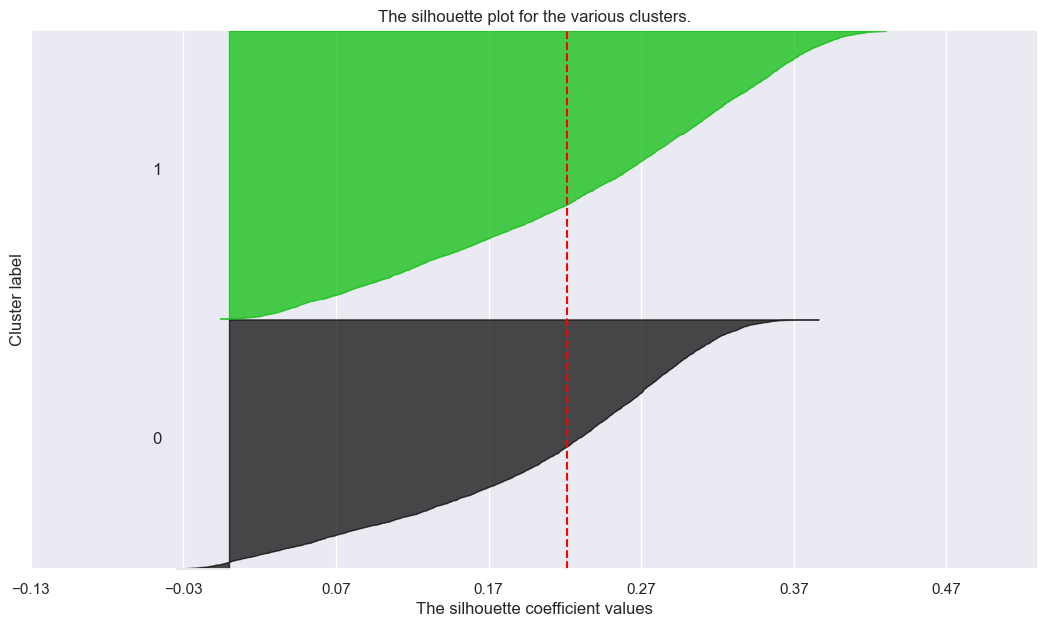

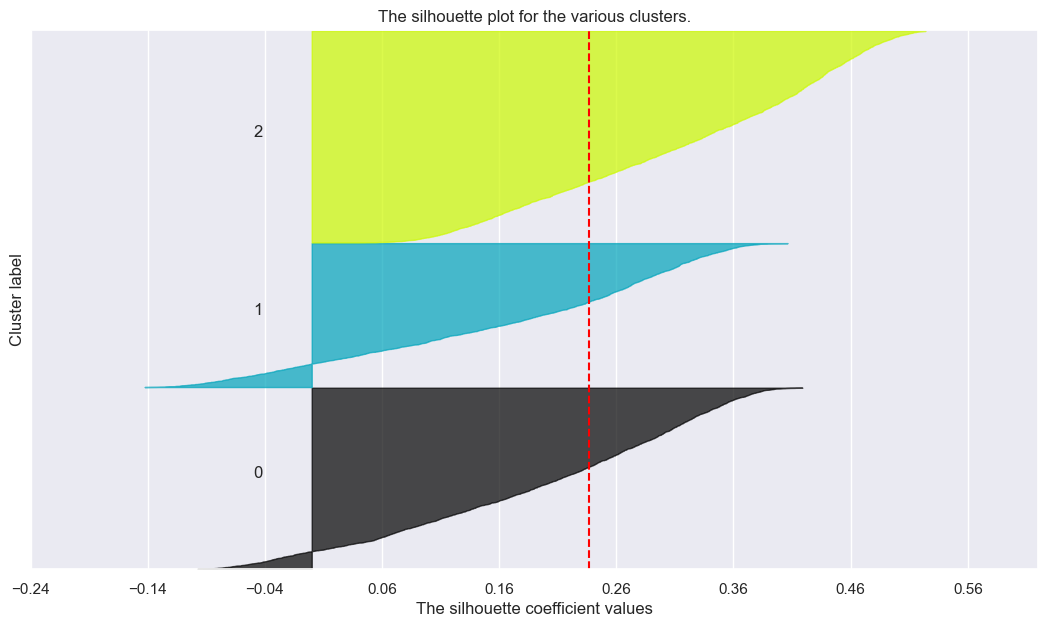

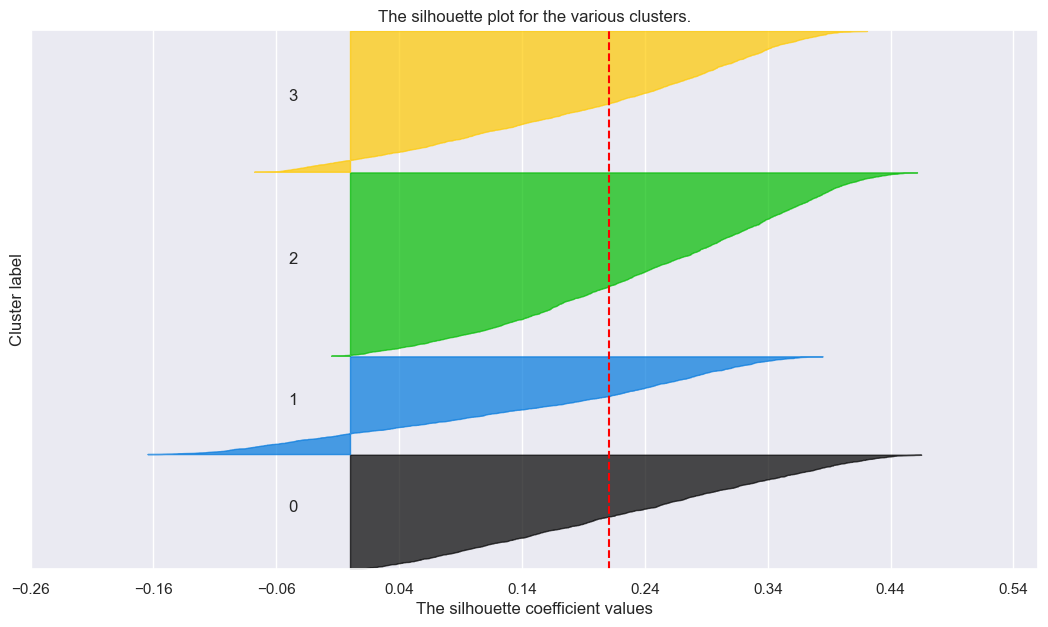

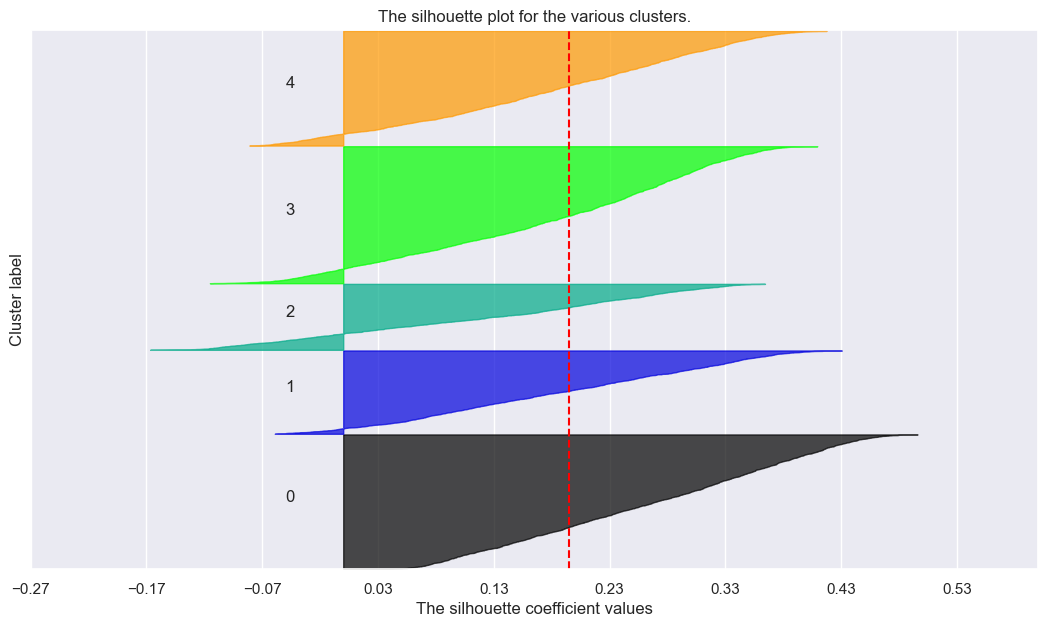

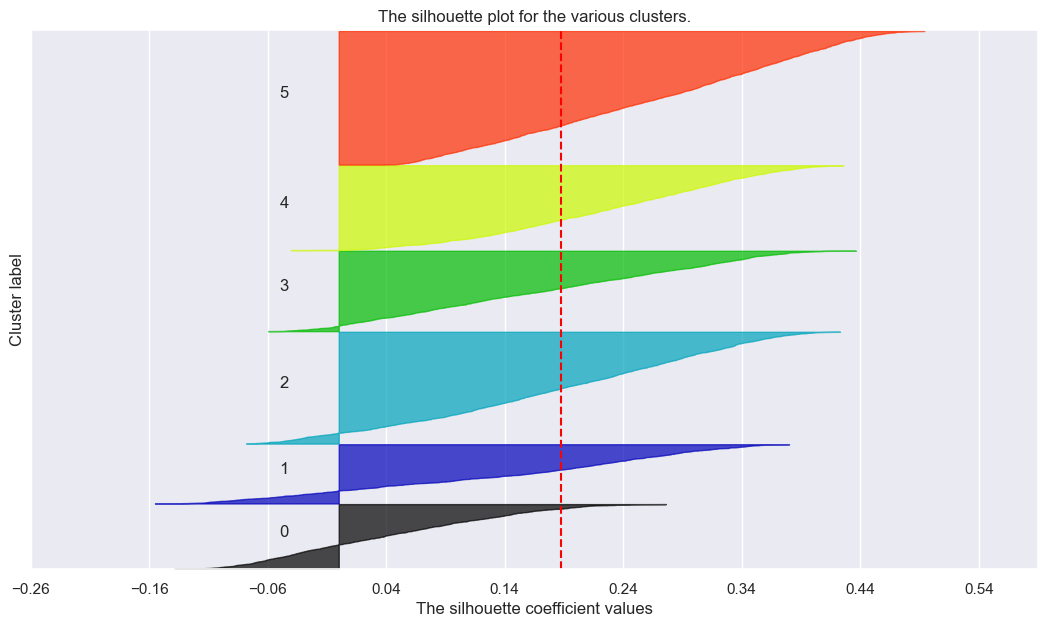

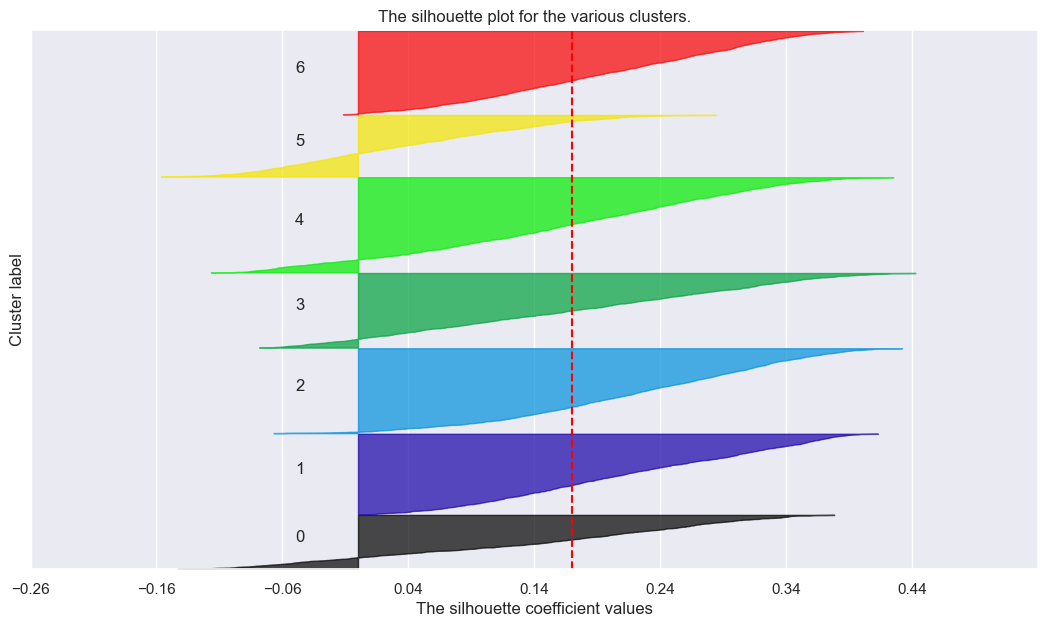

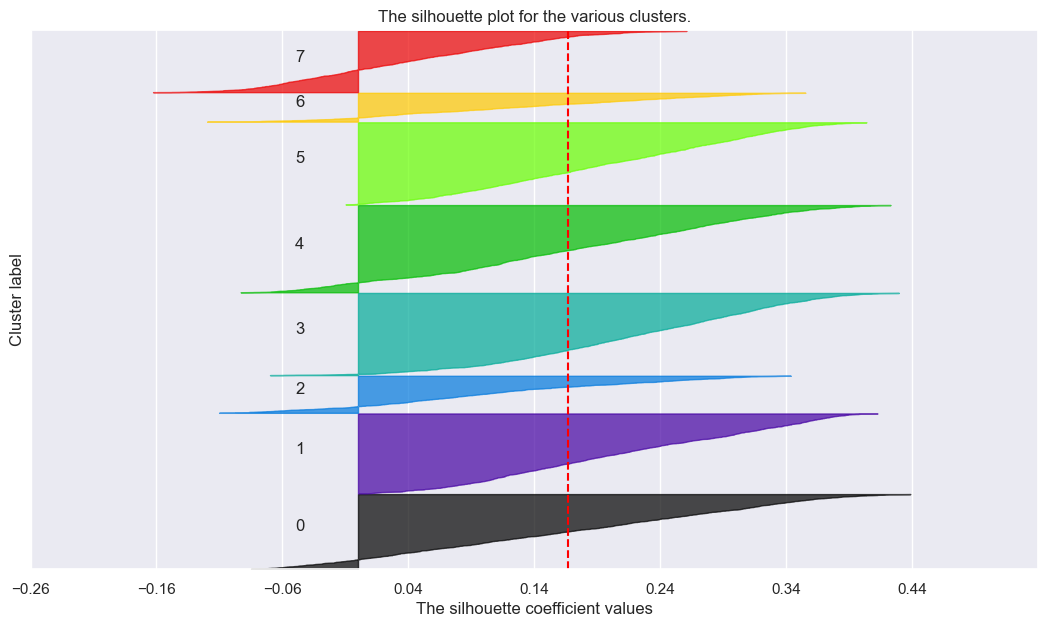

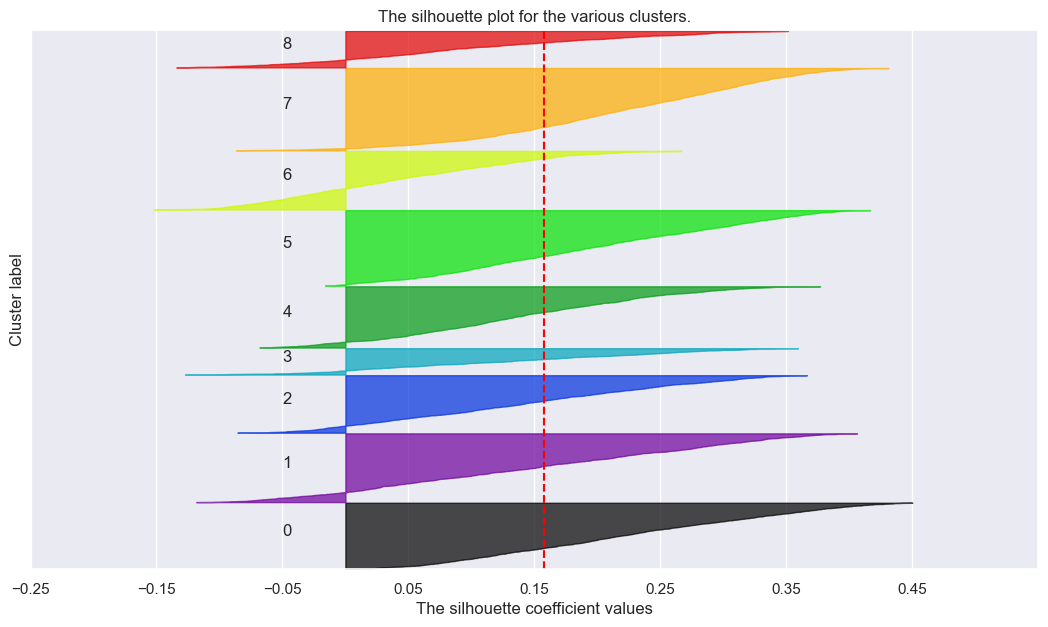

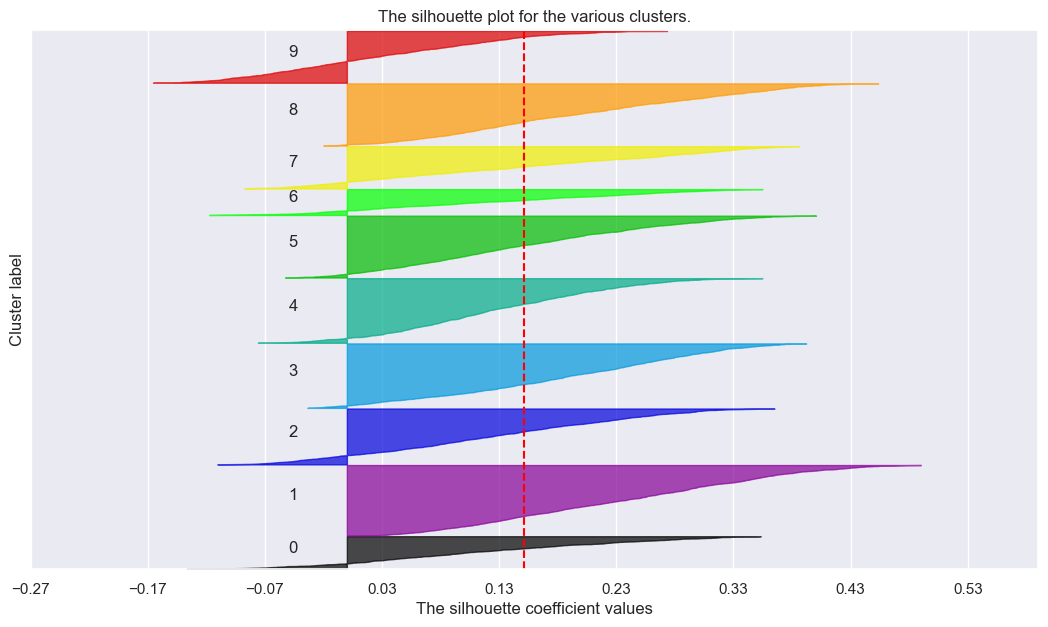

In [15]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

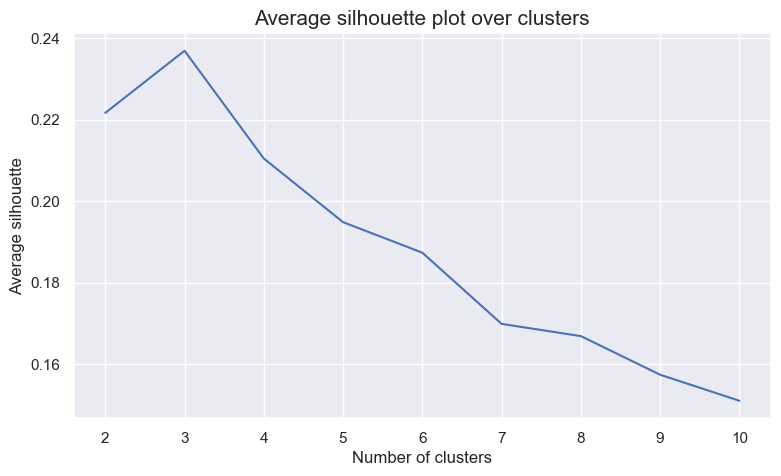

In [22]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters, ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

### Final KMeans clustering solution

In [24]:
# final cluster solution
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init="k-means++", n_init=300, random_state=42)
km_labels = kmclust.fit_predict(df[metric_features])
km_labels

array([2, 2, 0, ..., 1, 2, 3], dtype=int32)

In [26]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km_labels, name='labels', index=df.index)), axis=1)
df_concat.groupby('labels').mean().T

labels,0,1,2,3
income,-1.130283,-0.549564,1.086312,0.516470
frq,-0.845821,-0.743390,1.008931,0.680136
rcn,0.096484,0.046991,-0.078202,-0.062155
clothes,-1.295808,0.405789,-0.471857,1.042054
kitchen,1.209211,-0.409876,0.164410,-0.581353
small_appliances,0.277001,-0.052141,0.604325,-0.900298
toys,1.196060,-0.402123,0.173725,-0.594057
house_keeping,1.223475,-0.384729,0.112972,-0.570653
per_net_purchase,0.701017,0.541344,-1.234634,0.048942
spent_online,-0.769925,-0.618290,0.372184,1.199451


### How can we combine the 2 algorithms?

## Exercise:
**Apply Hierarchical Clustering and K-means on the Principal Components.**

Choose the appropriate parameters and number of clusters for each algorithm and interpret each cluster based on the Principal Components interpretation: